In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm

from msfm.utils import tfrecords, files, parameters, cross_statistics
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.grid_pipeline import GridPipeline
from msfm.utils.input_output import read_yaml

In [3]:
lensing_indices, _ = cross_statistics.get_cross_bin_indices(
    with_lensing=True, 
    with_clustering=False, 
    with_cross_z=False, 
    with_cross_probe=False
)
print(lensing_indices)

[0, 8, 15, 21]


In [4]:
clustering_indices, _ = cross_statistics.get_cross_bin_indices(
    with_lensing=False, 
    with_clustering=True, 
    with_cross_z=False, 
    with_cross_probe=False
)
print(clustering_indices)

[26, 30, 33, 35]


In [5]:
with_lensing = True
with_clustering = True

bin_indices, _ = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing, 
    with_clustering=with_clustering, 
    with_cross_z=True, 
    with_cross_probe=(with_lensing and with_clustering)
)

# fiducial

In [6]:
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0001.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_00??.tfrecord"
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias_debug.yaml"
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)

# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# params = ["Om", "s8"]
params = ["Om", "Aia"]
# params = ["s8", "Aia"]
# params = ["Om", "bg"]
# params = ["Om"]
# params = ["Aia"]
# params = ["bg"]

In [7]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    apply_norm=False,
)

data_vec_pix = fidu_pipe.data_vec_pix
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
n_z = fidu_pipe.n_z_metacal + fidu_pipe.n_z_maglim
n_z_metacal = fidu_pipe.n_z_metacal
n_noise = conf["analysis"]["fiducial"]["n_noise_per_example"]
# n_noise = [2]
fidu_batch_size = 1

fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    noise_indices=n_noise,
    local_batch_size=fidu_batch_size,
    n_readers=1,
    n_prefetch=0,
    is_eval=True,
)

# lensing bin 0
i_z_map = 0
i_z_cl = 0

# # clustering bin 0
# i_z_map = 4
# i_z_cl = 26


24-08-14 01:32:01     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-08-14 01:32:01     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-08-14 01:32:02 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-08-14 01:32:02 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-08-14 01:32:02 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-08-14 01:32:02 fiducial_pip INF   Including noise_indices = [0, 1] 
24-08-14 01:32:02 fiducial_pip INF   Interleaving with n_readers = 1 
24-08-14 01:32:03 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-08-14 01:32:04 fiducial_pip WAR   Tracing _augmentations 
Please repo

In [8]:
# for dv, cl, index in fidu_dset.take(3):
#     pass

# print(dv.shape)
# print(cl.shape)

### map-level perturbations translated to cl-level

In [9]:
# n_examples = 3
# for i, (dv, cl, index) in tqdm(enumerate(fidu_dset.take(n_examples)), total=n_examples):
#     if i==0:
#         print(dv.shape)
#         print(cl.shape)
    
#     batch_size = dv.shape[0]
#     dv_map = np.zeros((batch_size, n_pix))
#     dv_map[:,data_vec_pix] = dv[:,:,i_z_map]

#     fig, ax = plt.subplots(figsize=(4*batch_size,4), ncols=batch_size-1)
#     l_min, l_max = 30, 1000

#     dv_cl_fidu = hp.anafast(hp.reorder(dv_map[0], n2r=True))
#     for j in range(1,batch_size):
#         dv_map[j] = hp.reorder(dv_map[j], n2r=True)
#         dv_delta = hp.anafast(dv_map[j]) - dv_cl_fidu
#         cl_delta = cl[j,:,i_z_cl] - dv_cl_fidu

#         ax[j-1].plot(dv_delta[l_min:l_max], label="computed delta from map", alpha=0.5)
#         # ax[j-1].plot(np.abs(dv_delta[l_min:l_max]), label="abs computed delta from map", alpha=0.5)
#         ax[j-1].plot(cl_delta[l_min:l_max], label="loaded from tfr", alpha=0.5)
#         ax[j-1].grid(True)
#         ax[j-1].legend()
#         ax[j-1].set(yscale="log", title=f"{i}, {fidu_pipe.pert_labels[j//fidu_batch_size]}")


### comparison between the stored and computed (from maps) power spectra 

  0%|          | 0/16 [00:00<?, ?it/s]

(5, 460800, 8)
(5, 1536, 36)


 50%|█████     | 8/16 [01:09<01:09,  8.73s/it]


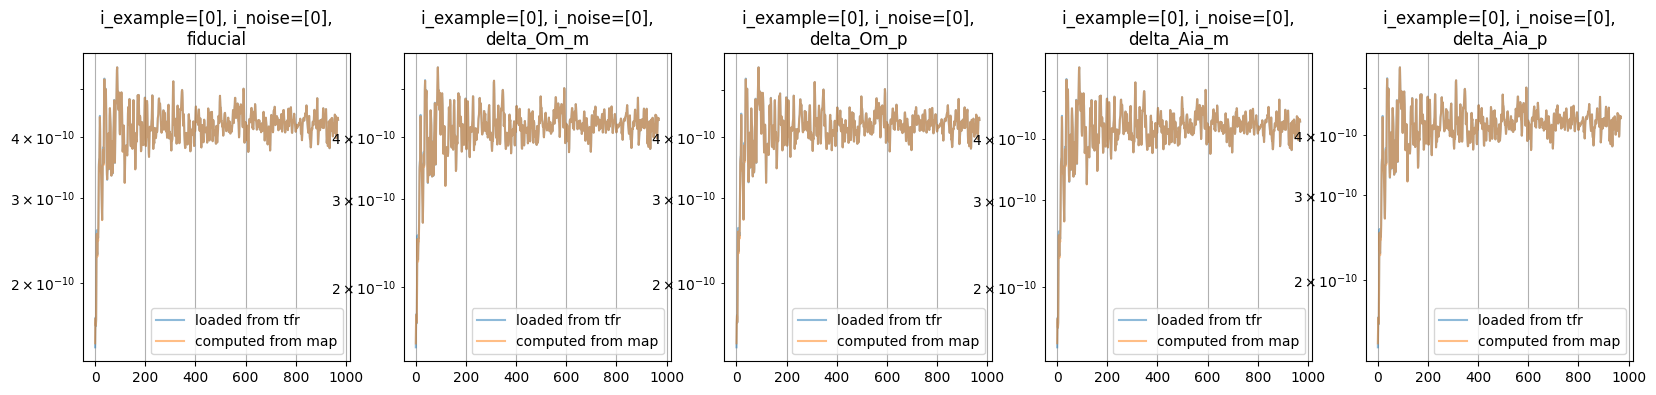

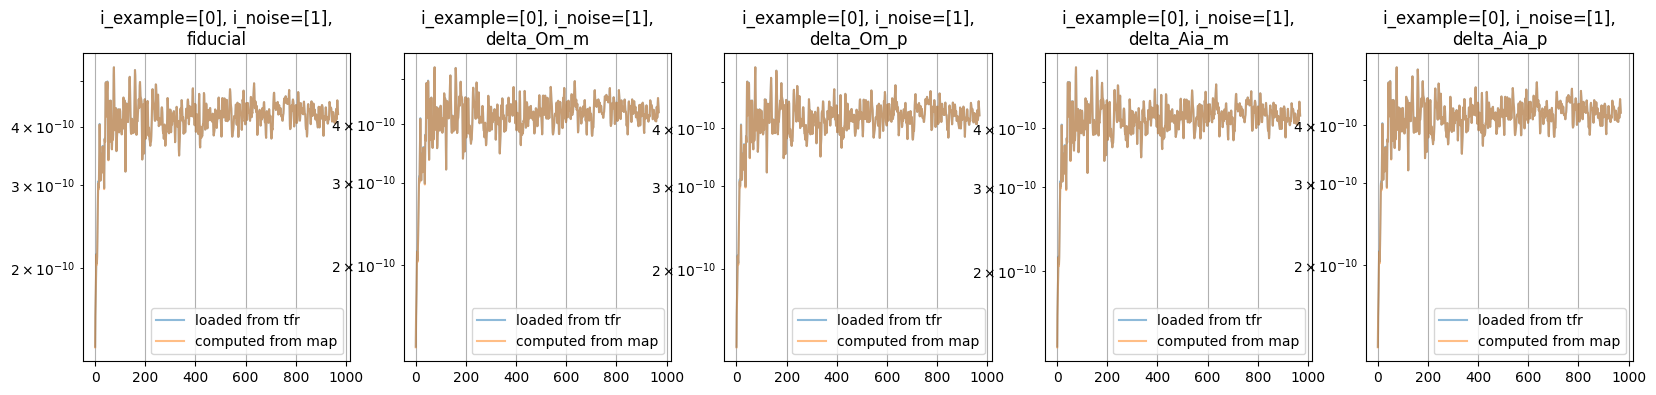

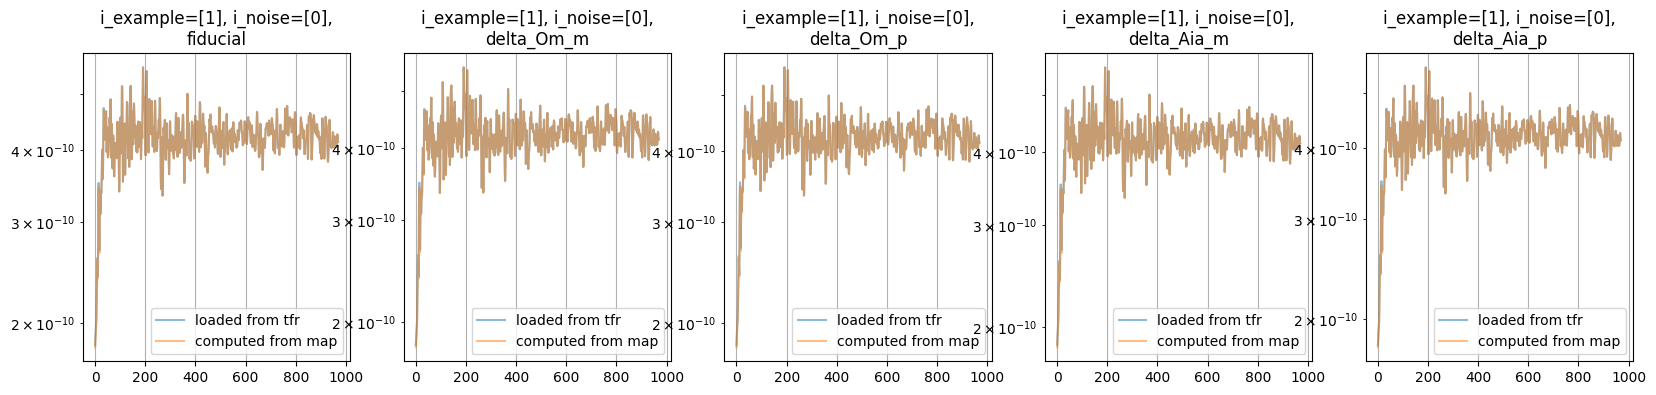

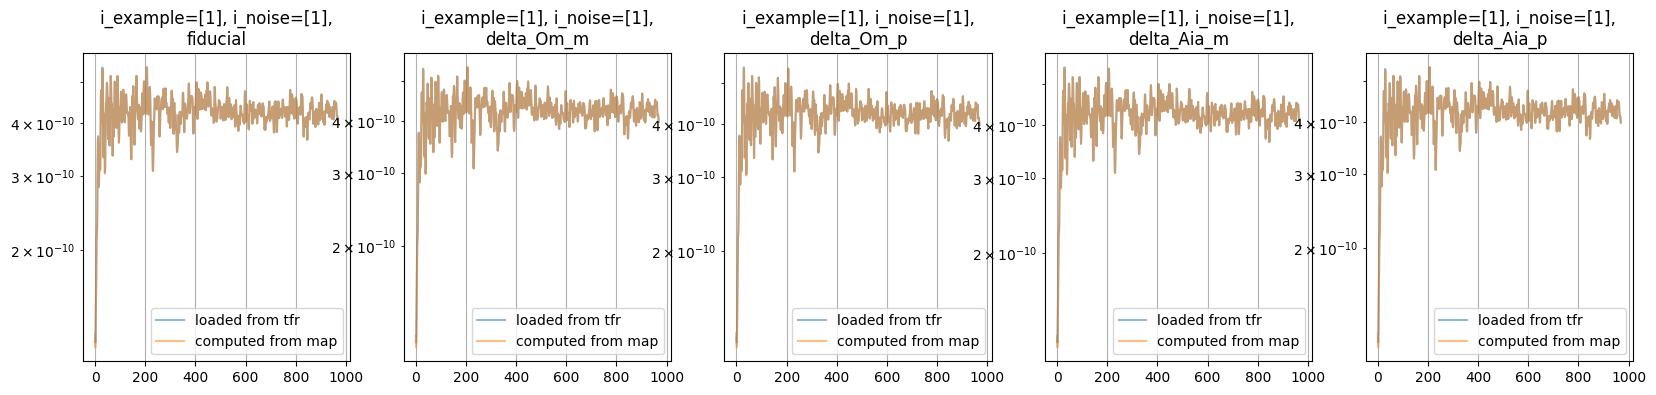

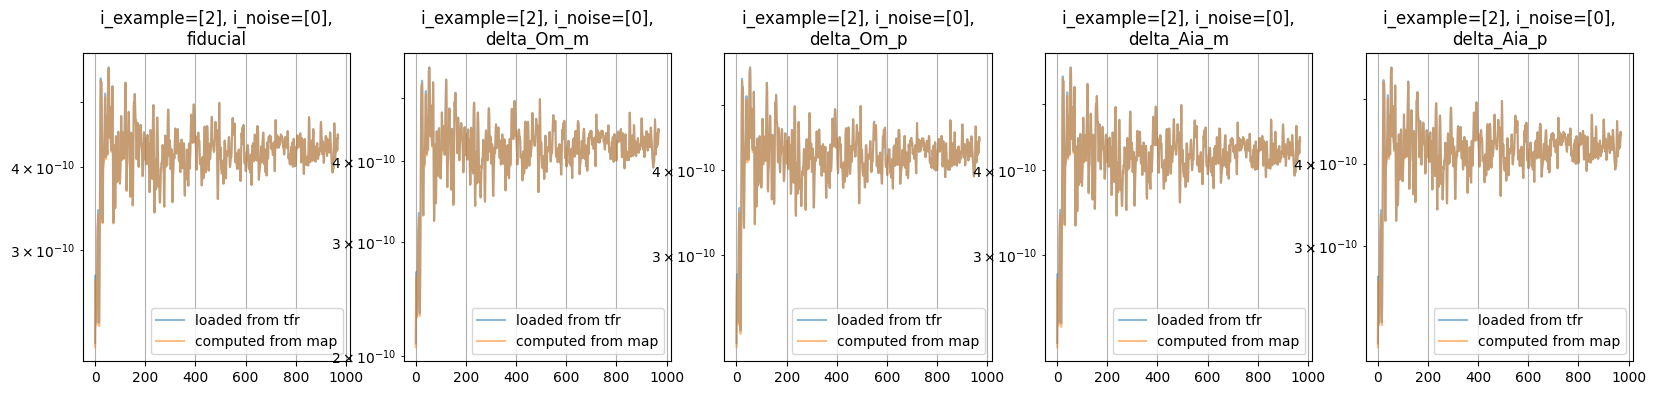

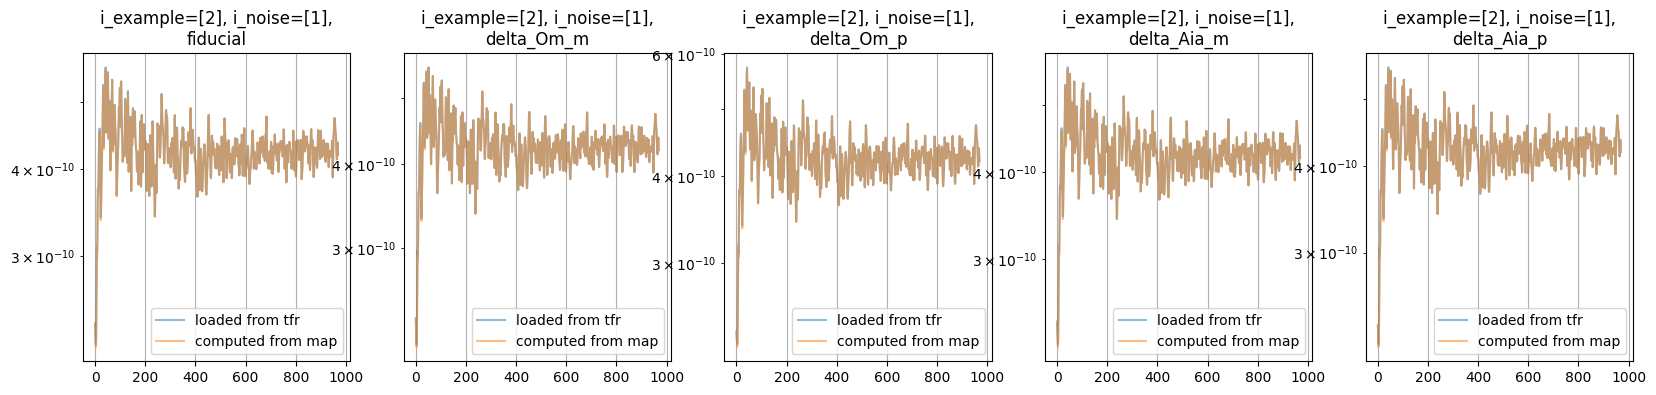

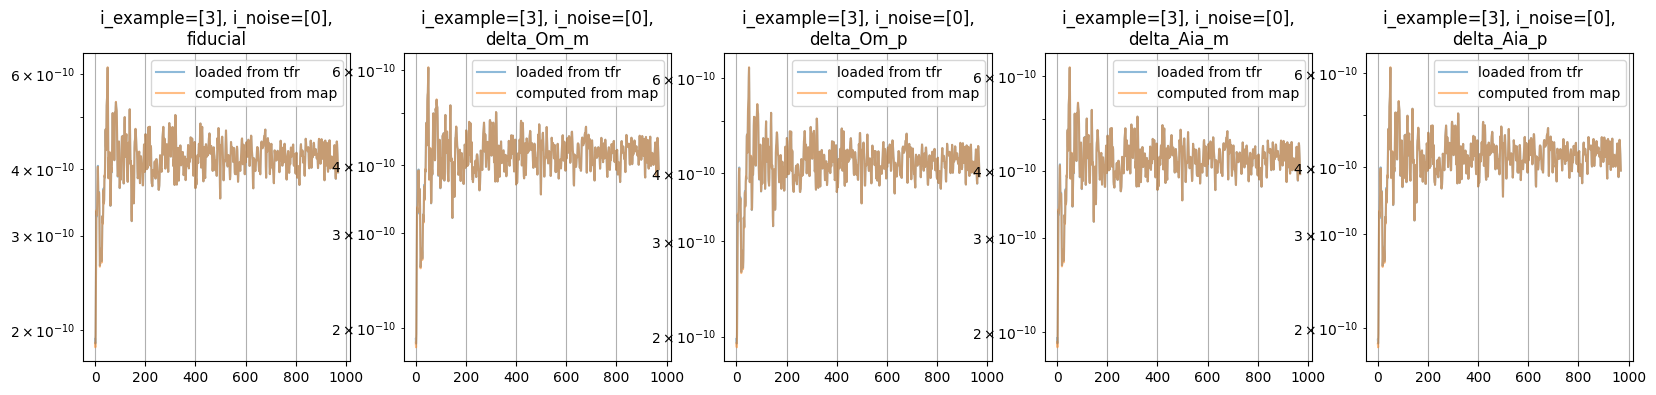

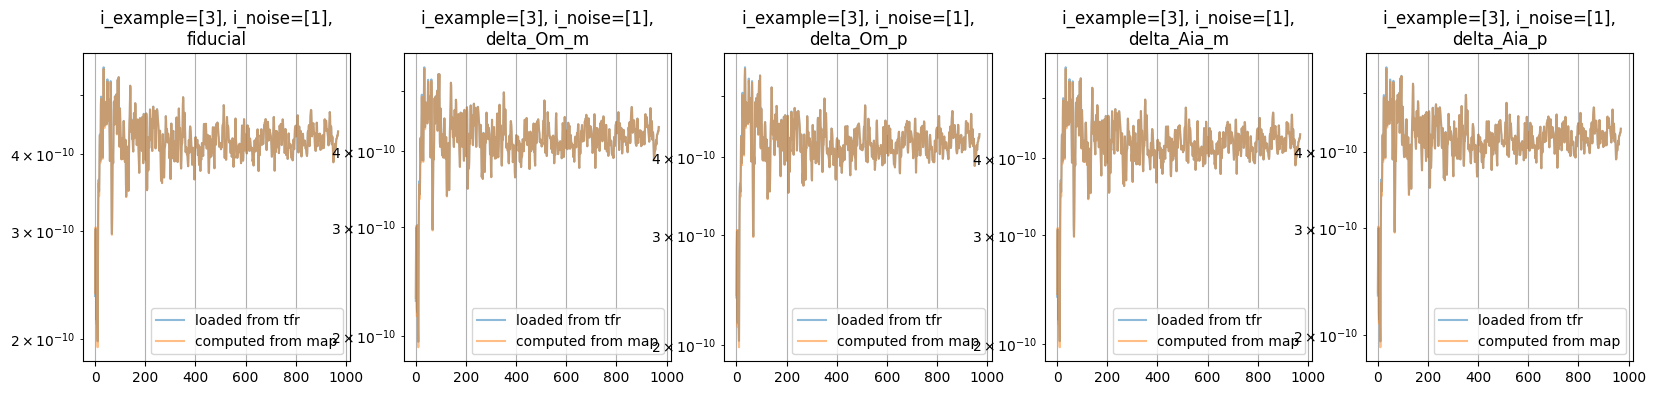

In [10]:
n_examples = 16
for i, (dv, cl, index) in tqdm(enumerate(fidu_dset.take(n_examples)), total=n_examples):
    if i==0:
        print(dv.shape)
        print(cl.shape)
    
    batch_size = dv.shape[0]
    dv_map = np.zeros((batch_size, n_pix))
    dv_map[:,data_vec_pix] = dv[:,:,i_z_map]

    fig, ax = plt.subplots(figsize=(4*batch_size,4), ncols=batch_size)
    l_min, l_max = 30, 1000

    for j in range(batch_size):
        dv_map[j] = hp.reorder(dv_map[j], n2r=True)
        # hp.mollview(dv_map)

        dv_cl = hp.anafast(dv_map[j])

        ax[j].plot(cl[j,l_min:l_max,i_z_cl], label="loaded from tfr", alpha=0.5)
        ax[j].plot(dv_cl[l_min:l_max], label="computed from map", alpha=0.5)
        ax[j].grid(True)
        ax[j].legend()
        ax[j].set(yscale="log", title=f"i_example={index[0].numpy()}, i_noise={index[1].numpy()},\n{fidu_pipe.pert_labels[j//fidu_batch_size]}")


In [11]:
# i_z = 0
# i_b = 1
# for i, (dv, cl, index) in enumerate(fidu_dset.take(5)):
#     if i==0:
#         print(dv.shape)
#         print(cl.shape)
    
#     dv_map = np.zeros(n_pix)
#     dv_map[data_vec_pix] = dv[i_b,:,i_z]
#     dv_map = hp.reorder(dv_map, n2r=True)
#     # hp.mollview(dv_map)
    
#     dv_cl = hp.anafast(dv_map)
    
#     l_min, l_max = 30, 1000
#     fig, ax = plt.subplots()
#     ax.plot(cl[i_b,l_min:l_max,i_z], label="loaded from tfr", alpha=0.5)
#     ax.plot(dv_cl[l_min:l_max], label="computed from map", alpha=0.5)
#     ax.grid(True)
#     ax.legend()
#     ax.set(yscale="log", title=f"example {i}")


# grid

In [12]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias_debug.yaml"
conf = files.load_config(conf)

params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]

In [13]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    apply_norm=False,
)

data_vec_pix = grid_pipe.data_vec_pix
n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = conf["analysis"]["grid"]["n_noise_per_example"]

grid_dset = grid_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    noise_indices=n_noise,
    local_batch_size=3,
    n_readers=1,
    n_prefetch=0,
)

24-08-14 01:33:24     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-08-14 01:33:24     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-08-14 01:33:25 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-08-14 01:33:25 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-08-14 01:33:25 grid_pipelin INF   Including noise_indices = [0, 1] 
24-08-14 01:33:25 grid_pipelin INF   Interleaving with n_readers = 1 
24-08-14 01:33:25 grid_pipelin INF   Batching into 3 elements locally 
24-08-14 01:33:26 grid_pipelin WAR   Tracing _augmentations 
24-08-14 01:33:26 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'cls', 'i_sobol', 'i_example', 'kg', 'dg', 'cl', 'i_noise']) 
24-08-14 01:33:26 grid_pipelin INF   Suc

(3, 460800, 8)
(3, 1536, 36)
(3, 460800, 8)
(3, 1536, 36)
(3, 460800, 8)
(3, 1536, 36)
(3, 460800, 8)
(3, 1536, 36)
(3, 460800, 8)
(3, 1536, 36)


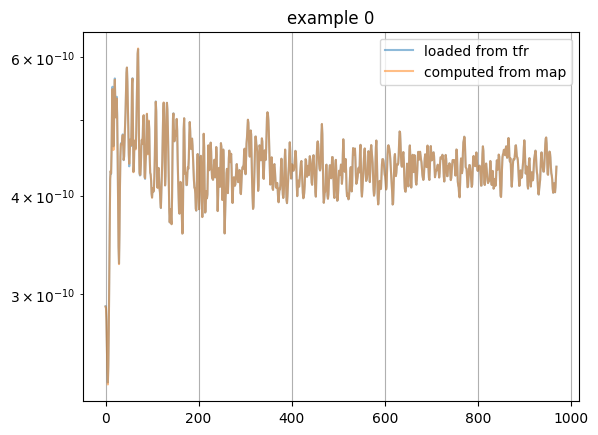

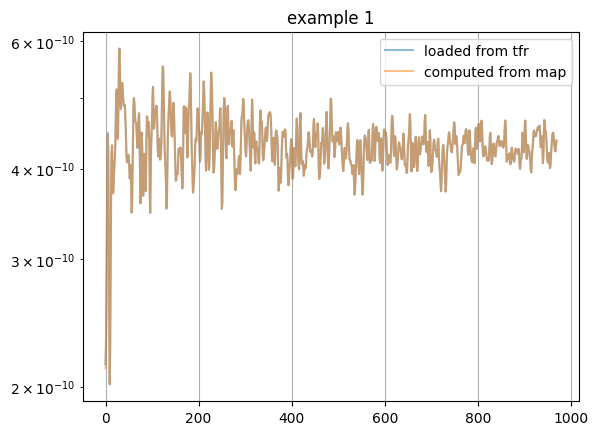

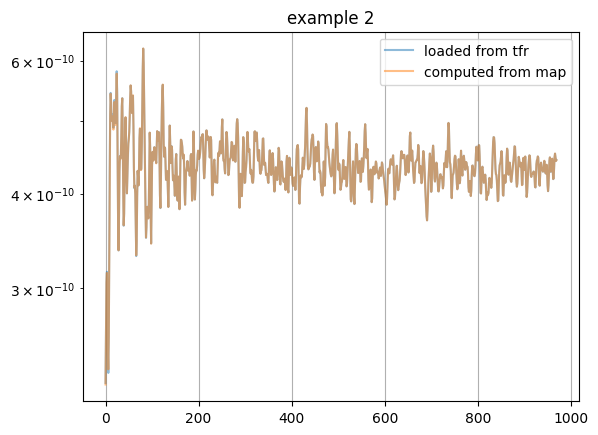

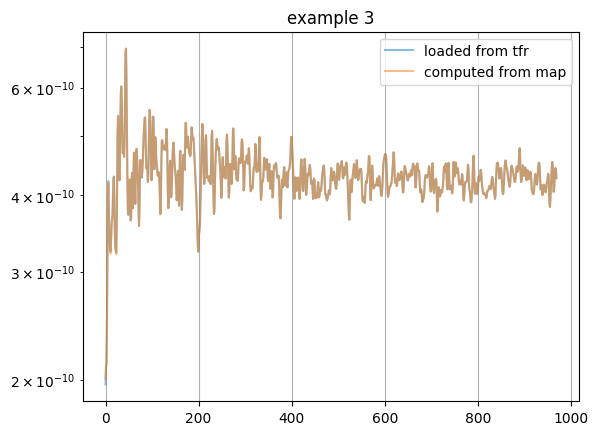

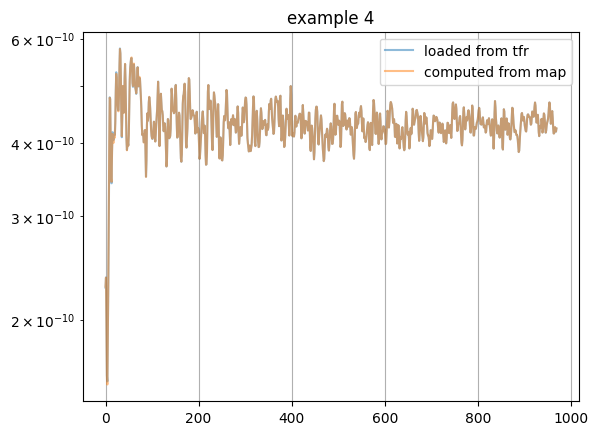

In [14]:
i_z = 0
i_b = 2
for i, (dv, cl, cosmo, index) in enumerate(grid_dset.skip(3).take(5)):
    print(dv.shape)
    print(cl.shape)
    
    dv_map = np.zeros(n_pix)
    dv_map[data_vec_pix] = dv[i_b,:,i_z]
    dv_map = hp.reorder(dv_map, n2r=True)
    # hp.mollview(dv_map)
    
    dv_cl = hp.anafast(dv_map)
    
    l_min, l_max = 30, 1000
    fig, ax = plt.subplots()
    ax.plot(cl[i_b,l_min:l_max,i_z], label="loaded from tfr", alpha=0.5)
    ax.plot(dv_cl[l_min:l_max], label="computed from map", alpha=0.5)
    ax.grid(True)
    ax.legend()
    ax.set(yscale="log", title=f"example {i}")
